In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("hotel_reviews.xlsx")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0


In [3]:
df.shape

(20491, 2)

In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  20491 non-null  object 
 1   Rating  20491 non-null  float64
dtypes: float64(1), object(1)
memory usage: 320.3+ KB


In [6]:
df.index

RangeIndex(start=0, stop=20491, step=1)

In [7]:
df.nunique()

Review    20491
Rating        5
dtype: int64

In [8]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [9]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [10]:
#Total no. of valuvalues in Rating columns
df["Rating"].value_counts()

5.0    9054
4.0    6039
3.0    2184
2.0    1793
1.0    1421
Name: Rating, dtype: int64

# EDA

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import warnings
warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

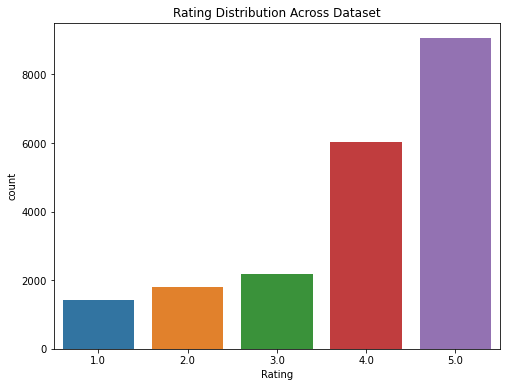

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(df["Rating"])
plt.title("Rating Distribution Across Dataset")

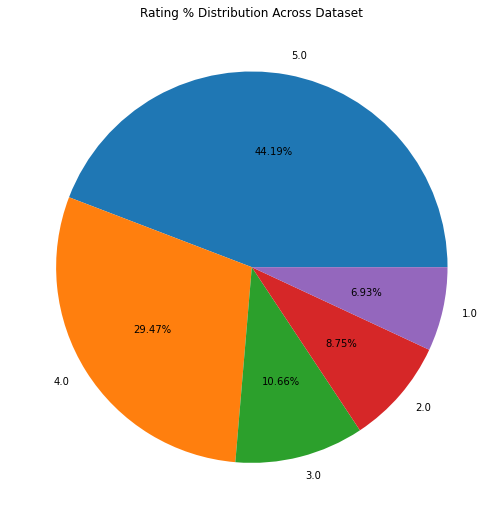

In [14]:
#Pie plot, the % of distribution of ratings across the dataset
plt.figure(figsize=(13,9))
plt.pie(df['Rating'].value_counts(),labels=['5.0','4.0','3.0','2.0','1.0'], autopct='%1.2f%%')
plt.title("Rating % Distribution Across Dataset")
plt.show()

<AxesSubplot:>

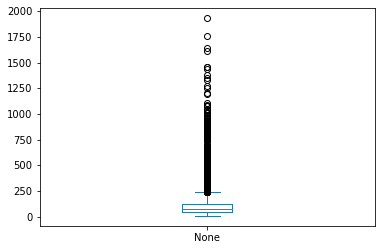

In [15]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in df['Review']])

# The distribution of review text lengths
review_len.plot(kind='box')

<AxesSubplot:ylabel='Count'>

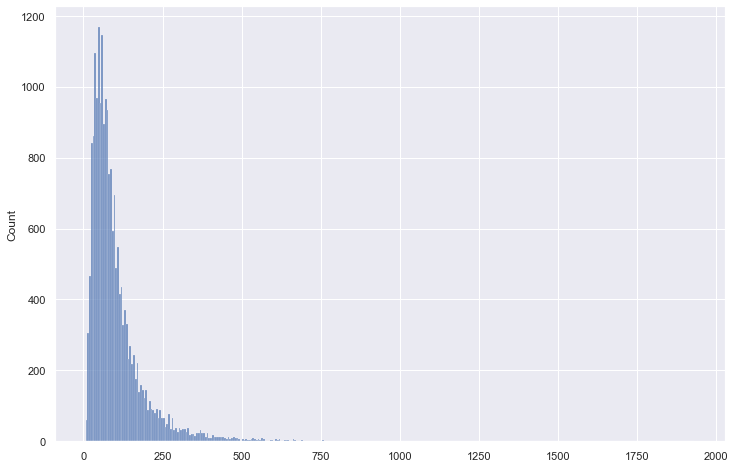

In [16]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)
plt.figure(figsize=(12,8))
sns.histplot(review_len)

count    9054.000000
mean       93.963773
std        90.977999
min         7.000000
25%        44.000000
50%        69.000000
75%       111.000000
max      1755.000000
Name: Length, dtype: float64

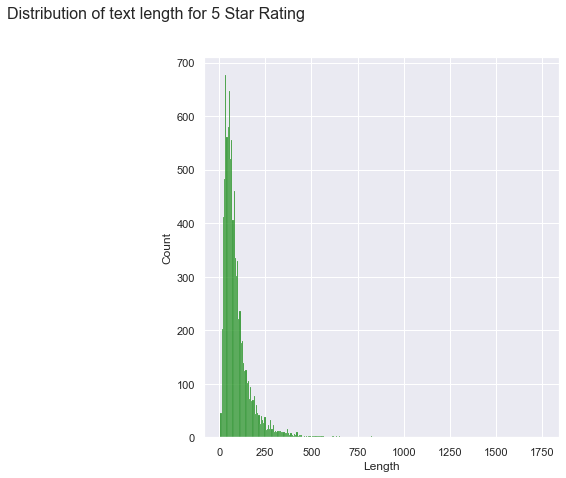

In [17]:
fig = plt.figure(figsize=(14,7))
df["Length"] = df.Review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Rating']==5]['Length'], ax=ax1,color='green')
fig.suptitle('Distribution of text length for 5 Star Rating', fontsize=16)
display(df.Length[df.Rating==5].describe())

count    1421.000000
mean      112.365236
std        99.834855
min        12.000000
25%        51.000000
50%        82.000000
75%       137.000000
max       954.000000
Name: Length, dtype: float64

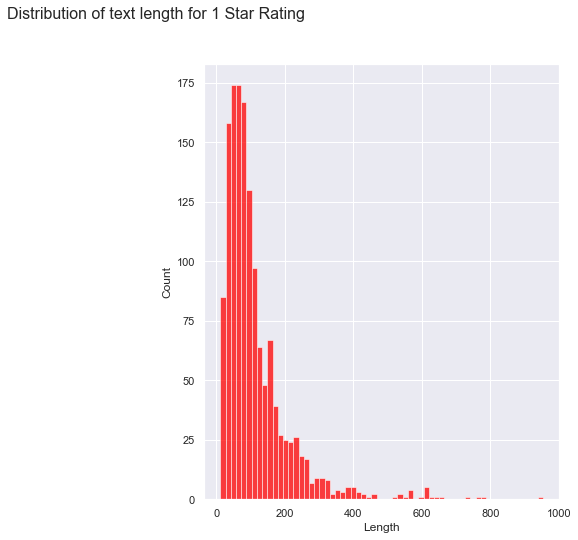

In [18]:
fig2 = plt.figure(figsize=(14,8))
ax2 = fig2.add_subplot(122)
sns.histplot(df[df["Rating"]==1]["Length"],ax=ax2,color='red')
fig2.suptitle("Distribution of text length for 1 Star Rating",fontsize=16)
display(df.Length[df.Rating==1].describe())

# WordCloud

In [19]:
from wordcloud import WordCloud

## WordCloud for Negatives Rating

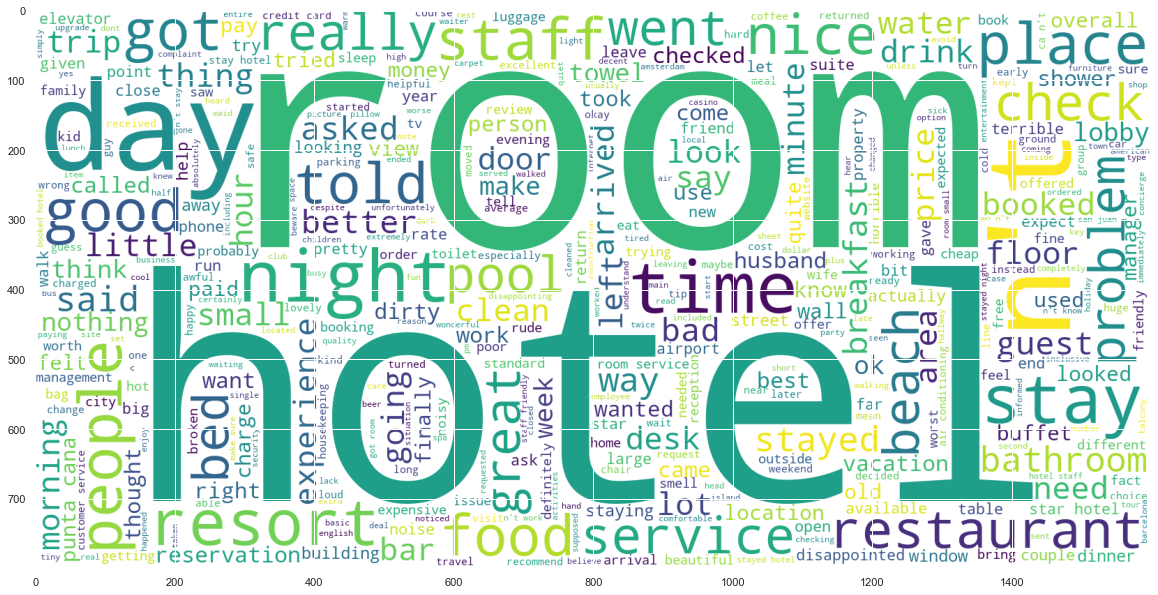

In [20]:
plt.figure(figsize=(20,20))
Neg_wc = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]<3].Review))
plt.imshow(Neg_wc)

## WordCloud for Neutral Rating

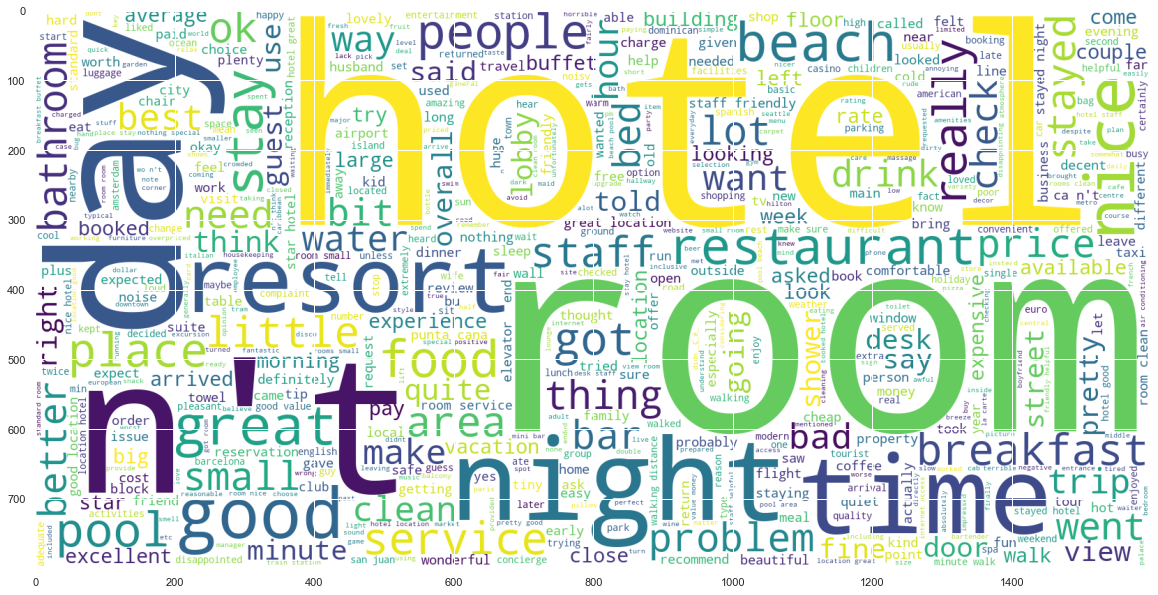

In [21]:
plt.figure(figsize=(20,20))
Neutral_wc = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==3].Review))
plt.imshow(Neutral_wc)

## WordCloud for Positive  Rating

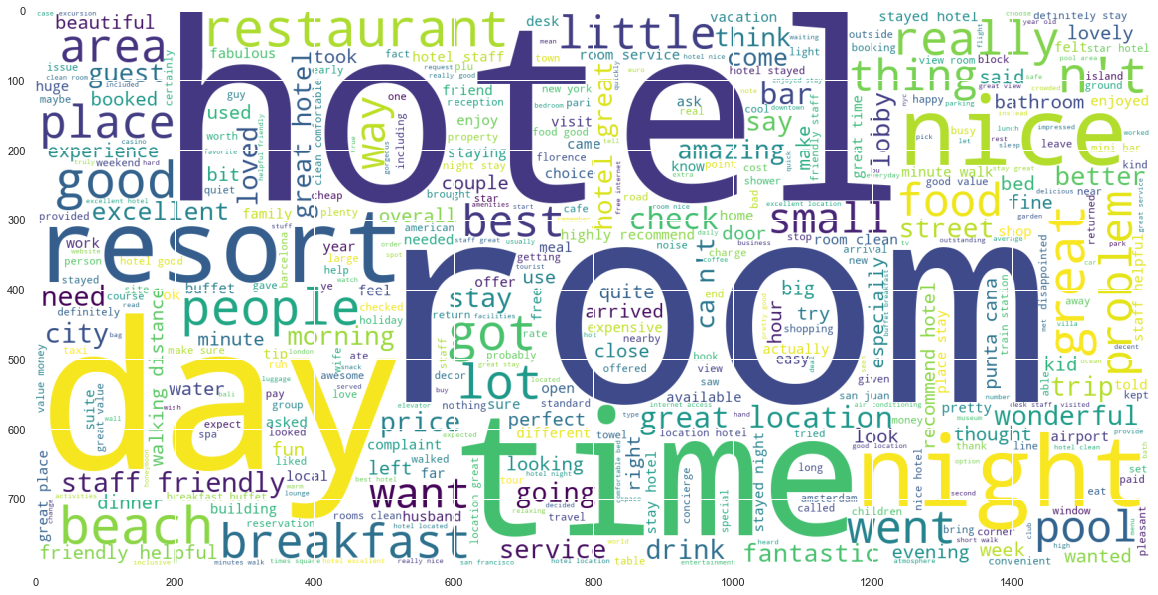

In [22]:
plt.figure(figsize=(20,20))
Pos_wc = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]>3].Review))
plt.imshow(Pos_wc)

# NLP Approach:
1. Cleaning
2. Lemmatization
3. TF-IDF

## 1. Data Cleaning Process

In [23]:
# function for cleaning Review
def standardize_text(df, field):
    df[field] = df[field].str.replace(r"http\S+", "")
    df[field] = df[field].str.replace(r"http","")
    df[field] = df[field].str.replace(r"@/S+","")
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\`\"\_\n]", " ")
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.lower()
    return df

In [24]:
standardize_text(df,"Review")

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4.0,87
1,ok nothing special charge diamond member hilto...,2.0,250
2,nice rooms not experience hotel monaco seat...,3.0,217
3,"unique, great stay, wonderful time hotel monac...",5.0,89
4,"great stay great stay, went seahawk game aweso...",5.0,191
...,...,...,...
20486,"best kept secret rd time staying charm, not ...",5.0,109
20487,great location price view hotel great quick pl...,4.0,39
20488,"ok just looks nice modern outside, desk staff ...",2.0,63
20489,hotel theft ruined vacation hotel opened sept ...,1.0,781


In [25]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91864\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Applying Lemmmatizer to remove tenses from texts.

In [26]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [27]:
corpus[:1]

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night']

# Polarity and subjectivity Score

In [28]:
import textblob
from textblob import TextBlob

In [29]:
df["Polarity_score"]=(round(df['Review'].apply(lambda x:TextBlob(x).sentiment.polarity),4))
df["Subjectivity_score"]=(round(df['Review'].apply(lambda x:TextBlob(x).sentiment.subjectivity),4))

In [30]:
df.head()

,Review,Rating,Length,Polarity_score,Subjectivity_score
0,nice hotel expensive parking got good deal sta...,4.0,87,0.2087,0.6870
1,ok nothing special charge diamond member hilto...,2.0,250,0.1974,0.5166
2,nice rooms not experience hotel monaco seat...,3.0,217,0.2673,0.6081
3,"unique, great stay, wonderful time hotel monac...",5.0,89,0.5048,0.6912
4,"great stay great stay, went seahawk game aweso...",5.0,191,0.3846,0.6294


In [31]:
#user def function

def sentiment(x):
    if x<-0.2:
        return 'negative'
    
    elif -0.2<x<0.2:
        return 'neutral'
    
    else:
        return 'positive'
    
df['Polarity']=df['Polarity_score'].map(lambda x: sentiment(x))

def sentiment(y):

    if y < 0.45:
        return "negative"
    
    elif 0.45<y<0.55:
        return "neutral"
    
    else:
        return "positive"
 
df['Subjectivity'] = df['Subjectivity_score'].apply(sentiment)
df.sample(20)

,Review,Rating,Length,Polarity_score,Subjectivity_score,Polarity,Subjectivity
10066,quality excellence having hotel tripadvisor co...,5.0,34,0.3784,0.3992,positive,negative
4510,gorgeous hotel taxi cab airport driver told be...,5.0,25,0.6262,0.6657,positive,positive
1653,nice choice great price stayed chancellor frid...,4.0,61,0.3702,0.5978,positive,positive
16177,"missed, stayed langham place hotel nights sp...",5.0,64,0.2747,0.5429,positive,neutral
7013,great entertainment husband punta cana th ann...,5.0,39,0.3906,0.5604,positive,positive
15772,"fantastic service shame pool shade, stayed hol...",4.0,67,0.3151,0.6901,positive,positive
19490,nice not husband honeymooned april riu p...,3.0,287,0.1079,0.5331,neutral,neutral
9944,treated royally palace stayed palazzo magnani ...,5.0,81,0.4244,0.6223,positive,positive
19088,"service style, hour wait immigration queue f...",4.0,85,0.2149,0.6713,positive,positive
13539,comfortable place good location hotel comforta...,3.0,24,0.3199,0.6130,positive,positive


In [32]:
df.Polarity.value_counts()

positive    14472
neutral      5735
negative      284
Name: Polarity, dtype: int64

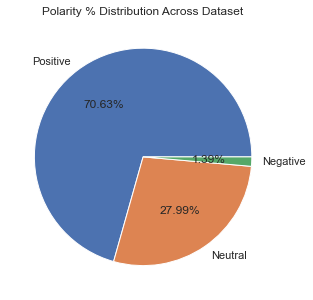

In [33]:
plt.figure(figsize=(8,5))
plt.pie(df['Polarity'].value_counts(),labels=['Positive','Neutral','Negative'],autopct='%1.2f%%')
plt.title("Polarity % Distribution Across Dataset")
plt.show()

## 3. Applying TF-IDF
Concept: Tfidf is meant for rendering more importance to the rare words. It so happens that if you rely on word counts alone, the unimportant words like ‘the’ , ‘and’ etc. will get more importance because they tend to get used more often.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1200, tokenizer = word_tokenize)#max features create feature matrix with the most frequently occuring words.(40000 columns)
x = tfidf.fit_transform(corpus).toarray()
x_feat=pd.DataFrame(x)
x_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.069752,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.079115,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.model_selection import train_test_split

In [36]:
Reviews=pd.concat([df["Polarity"],x_feat],axis=1)
Reviews.shape
Reviews.head(10)
#x.head()
x=Reviews.iloc[:,1:len(x_feat.columns)]
y=Reviews.iloc[:,0]
y2=y.values.reshape(1,-1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3) #test_size = 0.3 means 30% of the dataset
Reviews.shape
Reviews.head(3)

,Polarity,0,1,2,3,4,5,6,7,8,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,neutral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.069752,0.0,0.0,0.0,0.0,0.0
2,positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [37]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

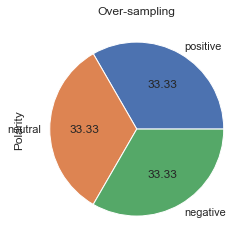

In [38]:
# define oversampling strategy. ros = random_over_sampler
ros = RandomOverSampler(sampling_strategy="auto")
x_res, y_res = ros.fit_resample(x, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [39]:
x=x_res
y=y_res
y2=y.values.reshape(1,-1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3) #test_size = 0.3 means 30% of the dataset
Reviews.shape
Reviews.head(3)

,Polarity,0,1,2,3,4,5,6,7,8,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,neutral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.069752,0.0,0.0,0.0,0.0,0.0
2,positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [40]:
Reviews.head(5)

,Polarity,0,1,2,3,4,5,6,7,8,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,positive,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,neutral,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.069752,0.0,0.0,0.0,0.0,0.0
2,positive,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,positive,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,positive,0.0,0.0,0.0,0.0,0.079115,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Model Training... 

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
from sklearn.metrics import accuracy_score,confusion_matrix,auc,classification_report,recall_score,precision_score,precision_recall_curve,f1_score,roc_curve

## Naive Bayes Classifier

In [43]:
from sklearn.naive_bayes import MultinomialNB
review_classifier_model=MultinomialNB()
review_classifier_model.fit(x_train,y_train)

MNB_train = review_classifier_model.predict(x_train)
np.mean(MNB_train==y_train)

MNB_test=review_classifier_model.predict(x_test)
np.mean(MNB_test==y_test)

multiNB_train_acc = round(accuracy_score(y_train,MNB_train),3)
multiNB_test_acc = round(accuracy_score(y_test,MNB_test),3)
multiNB_f1_score = round(f1_score(y_test,MNB_test,average='macro'),3)

print("MultinomialNB train accuracy score:", multiNB_train_acc)
print("MultinomialNB test accuracy score:", multiNB_test_acc)
print("MultinomialNB f1-score:", multiNB_f1_score)

print(classification_report(y_test,MNB_test))

MultinomialNB train accuracy score: 0.82
MultinomialNB test accuracy score: 0.811
MultinomialNB f1-score: 0.809
              precision    recall  f1-score   support

    negative       0.92      0.95      0.93      4391
     neutral       0.73      0.69      0.71      4276
    positive       0.78      0.79      0.78      4358

    accuracy                           0.81     13025
   macro avg       0.81      0.81      0.81     13025
weighted avg       0.81      0.81      0.81     13025



## Logistic Regression

In [44]:
# from sklearn.linear_model import LogisticRegression
# lr_model = LogisticRegression()
# lr_model.fit(x_train, y_train)
# lr_model.score(x_test, y_test)

In [45]:
# print(classification_report(y_test,lr_model.predict(x_test)))

In [46]:
# from sklearn.linear_model import LogisticRegression
# lr_model = LogisticRegression()
# lr_model.fit(x_train,y_train)

# LR_train = lr_model.predict(x_train)
# np.mean(LR_train==y_train)

# LR_test = lr_model.predict(x_test)
# np.mean(LR_test,y_train)

# multiLR_train_acc = round(accuracy_score(y_train,LR_train),3)
# multiLR_test_acc = round(accuracy_score(y_test,LR_test),3)
# multiLR_f1_score = round(f1_score(y_test,LR_test,avarege='macro'),3)

# print("Logistic Regression train accuracy score:", multiLR_train_acc)
# print("Logistic Regression test accuracy score:", multiLR_test_acc)
# print("Logistic Regression f1-score:", multiLR_f1_score)


# print(classification_report(y_test,LR_test))

## Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
dt_model=DecisionTreeClassifier(random_state=1,max_depth=25)
dt_model.fit(x_train,y_train)

dt_train=dt_model.predict(x_train)
np.mean(dt_train==y_train)

dt_test=dt_model.predict(x_test)
np.mean(dt_test==y_test)

dt_train_acc=round(accuracy_score(y_train,dt_train),3)
dt_test_acc=round(accuracy_score(y_test,dt_test),3)
dt_f1_score = round(f1_score(y_test,dt_test,average='macro'),3)

print("Decision Tree Train accuracy: ",dt_train_acc)
print("Decision Tree Test accuracy: ",dt_test_acc)
print("Decision Tree f1 score: ",dt_f1_score)


print(classification_report(y_test,dt_test))

Decision Tree Train accuracy:  0.954
Decision Tree Test accuracy:  0.87
Decision Tree f1 score:  0.867
              precision    recall  f1-score   support

    negative       0.91      1.00      0.96      4391
     neutral       0.79      0.84      0.82      4276
    positive       0.91      0.77      0.83      4358

    accuracy                           0.87     13025
   macro avg       0.87      0.87      0.87     13025
weighted avg       0.87      0.87      0.87     13025



## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_model=RandomForestClassifier(random_state=1)
rf_model.fit(x_train,y_train)

rf_train=rf_model.predict(x_train)
np.mean(rf_train==y_train)

rf_test=rf_model.predict(x_test)
np.mean(rf_test==y_test)

rf_train_acc=round(accuracy_score(y_train,rf_train),3)
rf_test_acc=round(accuracy_score(y_test,rf_test),3)
rf_f1_score = round(f1_score(y_test,rf_test,average='macro'),3)

print("Random Forest Train accuracy: ",rf_train_acc)
print("Random Forest Test accuracy: ",rf_test_acc)
print("Random Forest f1 score: ",rf_f1_score)

print(classification_report(y_test,rf_test))

Random Forest Train accuracy:  1.0
Random Forest Test accuracy:  0.948
Random Forest f1 score:  0.948
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      4391
     neutral       0.92      0.92      0.92      4276
    positive       0.92      0.92      0.92      4358

    accuracy                           0.95     13025
   macro avg       0.95      0.95      0.95     13025
weighted avg       0.95      0.95      0.95     13025



## AdaBoost

In [49]:
from sklearn.ensemble import AdaBoostClassifier

ada_model=AdaBoostClassifier(random_state=6)
ada_model.fit(x_train,y_train)

ada_train=ada_model.predict(x_train)
np.mean(ada_train==y_train)

ada_test=ada_model.predict(x_test)
np.mean(ada_test==y_test)

ada_train_acc=round(accuracy_score(y_train,ada_train),3)
ada_test_acc=round(accuracy_score(y_test,ada_test),3)
ada_f1_score = round(f1_score(y_test,ada_test,average='macro'),3)

print("AdaBoost train accuracy: ", ada_train_acc)
print("AdaBoost test accuracy: ", ada_test_acc)
print("AdaBoost f1 score: ", ada_f1_score)


print(classification_report(y_test,ada_test))

AdaBoost train accuracy:  0.776
AdaBoost test accuracy:  0.775
AdaBoost f1 score:  0.776
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89      4391
     neutral       0.66      0.66      0.66      4276
    positive       0.74      0.81      0.77      4358

    accuracy                           0.77     13025
   macro avg       0.78      0.77      0.78     13025
weighted avg       0.78      0.77      0.78     13025



## LightGBM

In [50]:
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier()
lgb_model.fit(x_train,y_train)

lgb_train=ada_model.predict(x_train)
np.mean(lgb_train==y_train)

lgb_test=lgb_model.predict(x_test)
np.mean(lgb_test==y_test)

lgb_train_acc=round(accuracy_score(y_train,ada_train),3)
lgb_test_acc=round(accuracy_score(y_test,ada_test),3)
lgb_f1_score = round(f1_score(y_test,lgb_test,average='macro'),3)

print("LightGBM train accuracy: ", lgb_train_acc)
print("LightGBM test accuracy: ", lgb_test_acc)
print("LightGBM f1 score: ", lgb_f1_score)


print(classification_report(y_test,ada_test))

LightGBM train accuracy:  0.776
LightGBM test accuracy:  0.775
LightGBM f1 score:  0.941
              precision    recall  f1-score   support

    negative       0.94      0.85      0.89      4391
     neutral       0.66      0.66      0.66      4276
    positive       0.74      0.81      0.77      4358

    accuracy                           0.77     13025
   macro avg       0.78      0.77      0.78     13025
weighted avg       0.78      0.77      0.78     13025



# Support Vector Classifier

In [51]:
from sklearn.svm import SVC
classifier_SVM=SVC()
classifier_SVM.fit(x_train,y_train)

SVM_train=classifier_SVM.predict(x_train)
np.mean(SVM_train==y_train)

SVM_test=classifier_SVM.predict(x_test)
np.mean(SVM_test==y_test)

SVM_train_acc = round(accuracy_score(y_train,SVM_train),3)
SVM_test_acc = round(accuracy_score(y_test,SVM_test),3)
SVM_f1_score = round(f1_score(y_test,SVM_test,average='macro'),3)


print("SVM train accuracy: ",SVM_train_acc)
print("SVM test accuracy: ",SVM_test_acc)
print("SVM f1 score: ", SVM_f1_score)

print(classification_report(y_test,SVM_test))

SVM train accuracy:  0.995
SVM test accuracy:  0.956
SVM f1 score:  0.956
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      4391
     neutral       0.91      0.96      0.93      4276
    positive       0.96      0.91      0.93      4358

    accuracy                           0.96     13025
   macro avg       0.96      0.96      0.96     13025
weighted avg       0.96      0.96      0.96     13025



# Model Accuracy Test

In [57]:
data=[['Multinomial NB',multiNB_test_acc,multiNB_f1_score],
         ['Decision Tree',dt_test_acc,dt_f1_score],['Random Forest',rf_test_acc,rf_f1_score],
         ['Ada Boost',ada_test_acc,ada_f1_score],['LightGBM',lgb_test_acc,lgb_f1_score],
      ['Support Vector Classifier',SVM_test_acc,SVM_f1_score]]

summary=pd.DataFrame(data,columns=['Model','test_accuracy','F1_score'])
summary

,Model,test_accuracy,F1_score
0,Multinomial NB,0.811,0.809
1,Decision Tree,0.870,0.867
2,Random Forest,0.948,0.948
3,Ada Boost,0.775,0.776
4,LightGBM,0.775,0.941
5,Support Vector Classifier,0.956,0.956


### Out of all the Models we used, SVC model performes best with Accuracy of 95%. So, we are considering  Support Vector Classifier Model.

# Saving The Model 

In [53]:
import pickle
from pickle import dump
dump(classifier_SVM,open('model_sentiment.pkl','wb'))
dump(tfidf,open('model_sentiment_tfidf.pkl','wb'))

In [27]:
# pip install streamlit

# ========================Park=================================

# Manually Testing the Model

In [54]:
test=input('Please enter a review for which sentiment needs to be predicted:\n')

Please enter a review for which sentiment needs to be predicted:
warwick bad good reviews warwick shocks staff quite rude rooms fairly dirty, cut asked bandaid did not, requested bottle opener did not better service


In [59]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

from nltk.corpus import stopwords
def cleaning(text):
    corpus = []
    text = decontracted(text)
    text = text.lower()                              #lowering the text
    text = re.sub(r'#\S+','',text)                   #Remove the hyper link
    text = re.sub('[^a-z]',' ',text)              #Remove the character other than alphabet
    text = text.split()
    text = [word for word in review if not word in set(stopwords.words('english'))]
    text=' '.join(text)
    corpus.append(text)
    return corpus

In [60]:
review_cleaned=cleaning(test)
type(review_cleaned)

list

In [61]:
review_cleaned

['p e p l e   l k n g   c   n   b e l e v e   e x c e l l e n   r n g   h e l   n   e   p r c   e x r e e l   h e l p f u l   f l u e n   l n g u g e   g   w   k e   w e l c e     p l c e   b   u p   n e x p e n v e   h e l   e x p e n v e   c   p l c e   b   e   n u n l   r   c h r   f u n e r l   h e   w l k n g   e p   h e l   g r l f r e n   e p   c n   e   c n   e p   l   g u   h n g n g   e k   h l l w   g r l f r e n   w e r   h u e   p r u n   p r c   r r n g e   x   f l l w n g   r n n g   e   n g h   w r n g   n f r n   c   f r e   r   c l e n   l r g e   b h r   l l   p b l e   n g h   g l   l e v e   f l l w n g   r n n g   r e c e n   e x e n e     u n l e   g h   b u g e   n   c r e   l k   f e e l   p l c e']

In [80]:
df=tfidf.transform(review_cleaned).toarray()
pred=classifier_SVM.predict(df)
label=pred[0]

if label==2:
    print('Positive')
elif label==0:
    print('Negative')
else:
    print('Neutral')

ValueError: X has 1200 features, but SVC is expecting 1199 features as input.